In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import copy


# 하이퍼파라미터 설정
batch_size = 64
epochs = 10
lr = 0.01

# 데이터 전처리 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# MNIST 데이터셋 로드
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)
train_mask = (train_dataset.targets >= 0) & (train_dataset.targets <= 8-1)
test_mask = (test_dataset.targets >= 0) & (test_dataset.targets <= 8-1)

train_dataset.data = train_dataset.data[train_mask]
train_dataset.targets = train_dataset.targets[train_mask]
test_dataset.data = test_dataset.data[test_mask]
test_dataset.targets = test_dataset.targets[test_mask]

# 데이터를 NumPy 배열로 변환
x_train = train_dataset.data.numpy().reshape(-1, 784)
x_test = test_dataset.data.numpy().reshape(-1, 784)
y_train = train_dataset.targets.numpy()
y_test = test_dataset.targets.numpy()

# PCA로 feature 축소
pca = PCA(n_components=8)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# 정규화 (표준 스케일러 사용)
scaler = StandardScaler()
x_train_pca = scaler.fit_transform(x_train_pca)
x_test_pca = scaler.transform(x_test_pca)

# PyTorch Tensor로 변환
x_train_pca, y_train = torch.tensor(x_train_pca, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
x_test_pca, y_test = torch.tensor(x_test_pca, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)


class Feature_data_loader(Dataset):
    def __init__(self,x_train,y_train):
        self.feature1 = x_train
        temp = copy.deepcopy(x_train)
        shuffle = torch.randperm(len(temp))
        self.feature2 = temp[shuffle]
        
        self.y1 = y_train
        temp_y = copy.deepcopy(y_train)
        self.y2 = temp_y[shuffle]
        
    def __len__(self):
        return len(self.feature1)
    def __getitem__(self,idx):
        input1 = self.feature1[idx]
        input2 = self.feature2[idx]
        if self.y1[idx] == self.y2[idx]:
            label = 1
        else:
            label = 0
        return [input1,input2],label


# DataLoader 생성


feature_loader = DataLoader(Feature_data_loader(x_train_pca, y_train),batch_size=batch_size,shuffle=True)
train_loader = DataLoader(TensorDataset(x_train_pca, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_pca, y_test), batch_size=batch_size, shuffle=False)


In [41]:
from kan import KAN, create_dataset
def reg(acts_scale,KAN_layer, factor=1,lamb_l1=1.,lamb_entropy=2.,lamb_coef=0.,lamb_coefdiff=0.):

    def nonlinear(x, th=1e-16):
        return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

    reg_ = 0.
    for i in range(len(acts_scale)):
        vec = acts_scale[i].reshape(-1, )

        p = vec / torch.sum(vec)
        l1 = torch.sum(nonlinear(vec))
        entropy = - torch.sum(p * torch.log2(p + 1e-4))
        reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

    # regularize coefficient to encourage spline to be zero
    for i in range(len(KAN_layer.act_fun)):
        coeff_l1 = torch.sum(torch.mean(torch.abs(KAN_layer.act_fun[i].coef), dim=1))
        coeff_diff_l1 = torch.sum(torch.mean(torch.abs(torch.diff(KAN_layer.act_fun[i].coef)), dim=1))
        reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

    return reg_
def accuracy(pred, true):
    # 예측값이 로짓 혹은 확률값인 경우, 최대 값을 가진 인덱스를 구함 (가장 확률이 높은 클래스)
    pred = pred.detach().cpu()
    true = true.cpu()
    try:
        pred_labels = torch.argmax(pred, dim=1)
    except:
        pred_labels = torch.round(pred)
    # 예측 레이블과 실제 레이블이 일치하는 경우를 계산
    correct = (pred_labels == true).sum()
    # 정확도를 계산
    acc = correct / true.size(0)
    return acc.item() 

class Early_stop_train():
    def __init__(self,model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        

        
        self.loss_list = [1e100]
        self.acc_list = []
        self.stop_count = 0
        
    def train_model(self,train_loader,test_loader=None ,epochs=200,res = 10):
        #self.model.train()
        for epoch in range(epochs):
            if self.stop_count>=res:
                break
            loss_val,_ = self.test(test_loader)
            self.loss_list.append(loss_val)
            
            if self.loss_list[-1]>=np.min(self.loss_list[:-1]):
                self.stop_count+=1
            else:
                self.stop_count = 0
            loss_list = []
            acc_list = []
            for X_train,y_train in train_loader:
                y_train = y_train.type(torch.float32)
                self.optimizer.zero_grad()
                output = self.model(X_train)
                reg_ = 0.1*reg(self.model.KAN.acts_scale,self.model.KAN)
                try:
                    y_train = y_train.type(torch.float32)
                    loss = self.criterion(output.squeeze(), y_train)+reg_
                except:
                    y_train = y_train.long()
                    loss = self.criterion(output.squeeze(), y_train)+reg_
                loss.backward()
                self.optimizer.step()
                loss_list.append(loss.item())
                acc = accuracy(output,y_train)
                acc_list.append(acc)
                sys.stdout.write(f"\rEpoch {epoch+1} Loss {np.mean(loss_list):4f} acc : {np.mean(acc_list):4f} reg : {reg_:4f} stop count : {self.stop_count}")

    def test(self,test_loader):
        if test_loader is None:
            return 0,0
        else:
            self.model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data, target
                    output = self.model(data)
                    test_loss += nn.functional.cross_entropy(output, target, reduction='sum').item()
                    pred = output.argmax(dim=1, keepdim=True)
                    correct += pred.eq(target.view_as(pred)).sum().item()
            test_loss /= len(test_loader.dataset)
            print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')
            return test_loss,correct

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pennylane as qml
from pennylane import numpy as np
result_list_classical = []
for seed in [115,151,123,8,25]:
    # 데이터 로드 및 전처리
    """
    data = load_breast_cancer()
    X = data.data
    y = data.target

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=8)
    X_pca = pca.fit_transform(X_scaled)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.8, random_state=seed)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)"""

    # Pennylane 장치 설정
    dev = qml.device("default.qubit", wires=8)


    def ZZFeatureMapLayer(features, wires):
        """사용자 정의 ZZFeatureMap 레이어"""
        index = 0
        for i in wires:
            qml.Hadamard(wires=i)
            qml.RZ(features[:,index], wires=i)
            index += 1

        for j in range(0, len(wires)-1):
            qml.CNOT(wires=[j, j+1])
            qml.RZ((features[:,index]), wires=j+1)
            qml.CNOT(wires=[j, j+1])
            index+=1
    
    def ansatz(params):
        for j in range(len(params)):
            # 각 큐비트에 대해 RX, RY, RZ 회전 적용
            for i in range(len(params[0])):
                qml.RY(params[j, i, 0], wires=i)
                qml.RZ(params[j, i, 1], wires=i)
                
            # 인접한 큐비트 간 CNOT 게이트로 엔탱글링
            if j == len(params)-1:
                pass
            else:
                for i in range(len(params[0])-1):
                    qml.CNOT(wires=[i, i+1])


    # 양자 레이어 정의
    @qml.qnode(dev, interface='torch')
    def QuantumLayer(features,params):
        ZZFeatureMapLayer(features, wires=range(8))
        ansatz(params)
        return qml.probs(wires=[0,1,2])

    
    ## 양자 커널
    @qml.qnode(dev, interface='torch')
    def Kernal(features1,features2):
        ZZFeatureMapLayer(features1, wires=range(8))
        qml.adjoint(ZZFeatureMapLayer)(features2,wires=range(8))
        return qml.probs(wires=range(8))
    
    
    class Feature_model(nn.Module):
        def __init__(self):
            super(Feature_model,self).__init__()
            self.KAN = KAN([8,5,8*2-1],grid=10)
            self.Kernal = Kernal
        def forward(self,inputs):
            input1 = inputs[0]
            #input1_copy = input1.clone().detach().requires_grad_(True)
            input2 = inputs[1]
            #input2_copy = input2.clone().detach().requires_grad_(True)
            input1 = self.KAN(input1)
            #input1 = torch.concat([input1,input1_copy],dim=1)
            input2 = self.KAN(input2)
            #input2 = torch.concat([input2,input2_copy],dim=1)
            output = self.Kernal(input1,input2)
            output = output.type(torch.float32)
            return output[:,0]
            
        

    
    
    # 하이브리드 모델 정의
    class HybridModel(nn.Module):
        def __init__(self):
            super(HybridModel, self).__init__()
            self.KAN = feature_model.KAN
            
            self.quantum_layer = QuantumLayer
            self.Q_params = nn.Parameter((torch.rand([8,8,2])*2-1)*np.pi,requires_grad=True)
        def forward(self, x):
            x = self.KAN(x)
            #print(qml.draw(self.quantum_layer)(x,self.Q_params))
            quantum_output = self.quantum_layer(x,self.Q_params)
            quantum_output = quantum_output.type(torch.float32)
            return torch.log(quantum_output)
        
    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.cls_layer_1 = nn.Linear(8,8*2)
            self.cls_layer_2 = nn.Linear(8*2,8*2-1)
            self.output_layer = nn.Linear(8*2-1,8)
        def forward(self, x):
            x = self.cls_layer_1(x)
            x = nn.ReLU()(x)
            x = self.cls_layer_2(x)
            x = nn.ReLU()(x)
            output = self.output_layer(x)
            return output
    # 모델, 손실 함수, 최적화 설정
    
    
    feature_model = Feature_model(); criterion = nn.BCELoss()
    
    
    optimizer = optim.Adam(feature_model.parameters(), lr=0.01)


    # 모델 학습 및 평가
    train_process = Early_stop_train(feature_model, optimizer, criterion)
    train_process.train_model(feature_loader,epochs=5)
    
    para_dict = {}

    for key in model.state_dict().keys():
        try:
            para_dict[key]=feature_model.state_dict()[key]
        except:
            para_dict[key]=model.state_dict()[key]
    
    model = HybridModel(); criterion = nn.NLLLoss()

    for param in model.KAN.parameters():
        param.requires_grad = False
    for param in model.KAN.parameters():
        print(param.requires_grad)
    train_process = Early_stop_train(model, optimizer, criterion)
    train_process.train_model(feature_loader,epochs=15)
    
    _,accuracy = train_process.test(test_loader)
    result_list_classical.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}")



Epoch 1 Loss 2.184938 acc : 0.789909 reg : 1.058526 stop count : 0

KeyboardInterrupt: 

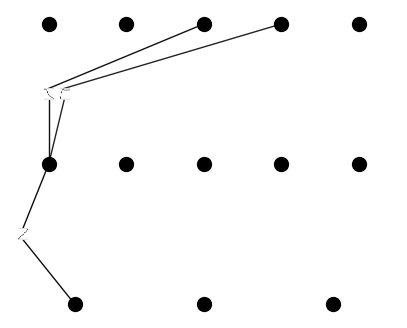

In [38]:
model.KAN.plot()

In [ ]:
def quantum_circuit(params):
    for j in range(len(params)):
        # 각 큐비트에 대해 RX, RY, RZ 회전 적용
        for i in range(len(params[0])):
            qml.RX(params[0, i, 0], wires=i)
            qml.RY(params[0, i, 1], wires=i)
            qml.RZ(params[0, i, 2], wires=i)
        
        # 인접한 큐비트 간 CNOT 게이트로 엔탱글링
        for i in range(len(params[0])-1):
            qml.CNOT(wires=[i, i+1])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pennylane as qml
from pennylane import numpy as np
result_list = []
for seed in [115,151,123,8,25]:
    # 데이터 로드 및 전처리
    data = load_breast_cancer()
    X = data.data
    y = data.target

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=8)
    X_pca = pca.fit_transform(X_scaled)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=seed)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Pennylane 장치 설정
    dev = qml.device("default.qubit", wires=8)


    def ZZFeatureMapLayer(features, wires):
        """사용자 정의 ZZFeatureMap 레이어"""
        index = 0
        for i in wires:
            qml.Hadamard(wires=i)
            qml.RZ(features[:,index], wires=i)
            index += 1
        for i in range(1):
            for j in range(i + 1, len(wires)):
                qml.CNOT(wires=[i, j])
                qml.RZ((features[:,index]), wires=j)
                qml.CNOT(wires=[i, j])
                index+=1

    # 양자 레이어 정의
    @qml.qnode(dev, interface='torch')
    def QuantumLayer(features,params):
        ZZFeatureMapLayer(features, wires=range(8))
        qml.BasicEntanglerLayers(params, wires=range(8),rotation=qml.RX)
        return qml.expval(qml.PauliZ(0))

    # 하이브리드 모델 정의
    class HybridModel(nn.Module):
        def __init__(self):
            super(HybridModel, self).__init__()
            self.cls_layer_1 = nn.Linear(8,8*2)
            self.cls_layer_2 = nn.Linear(8*2,8*2-1)
            
            self.quantum_layer = QuantumLayer
            Q_params = nn.Parameter(torch.rand([2,8],requires_grad=True))
            self.Q_params = torch.nn.init.xavier_uniform(Q_params)
        def forward(self, x):
            x = self.cls_layer_1(x)
            x = nn.ReLU()(x)
            x = self.cls_layer_2(x)
            x = nn.Sigmoid()(x)
            x = x*np.pi
            #print(qml.draw(self.quantum_layer)(x,self.Q_params))
            quantum_output = self.quantum_layer(x,self.Q_params)
            quantum_output = quantum_output.type(torch.float32)
            quantum_output = (quantum_output+1)/2
            return quantum_output
        
    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.cls_layer_1 = nn.Linear(8,8*2)
            self.cls_layer_2 = nn.Linear(8*2,8*2-1)
            self.output_layer = nn.Linear(8*2-1,1)
        def forward(self, x):
            x = self.cls_layer_1(x)
            x = nn.ReLU()(x)
            x = self.cls_layer_2(x)
            x = nn.ReLU()(x)
            output = self.output_layer(x)
            output = nn.Sigmoid()(output)
            return output
    # 모델, 손실 함수, 최적화 설정
    model = HybridModel()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)


    # 모델 학습 및 평가
    train_process = Early_stop_train(model, optimizer, criterion)
    train_process.train_model()
    accuracy = train_process.evaluate_model()
    result_list.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}")

C:\Users\pop75\AppData\Local\Temp\ipykernel_32884\2305901559.py:63: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.Q_params = torch.nn.init.xavier_uniform(Q_params)


Epoch 1 Loss 0.6606189012527466 acc : 0.6612486839294434 stop count : 0
Epoch 2 Loss 0.6599441766738892 acc : 0.6607721447944641 stop count : 0
Epoch 3 Loss 0.6594443917274475 acc : 0.6602181792259216 stop count : 0
Epoch 4 Loss 0.6588974595069885 acc : 0.6594597697257996 stop count : 0
Epoch 5 Loss 0.6581461429595947 acc : 0.6583967804908752 stop count : 0
Epoch 6 Loss 0.6570683717727661 acc : 0.6569231152534485 stop count : 0
Epoch 7 Loss 0.6555571556091309 acc : 0.6548988223075867 stop count : 0
Epoch 8 Loss 0.6534753441810608 acc : 0.6522341370582581 stop count : 0
Epoch 9 Loss 0.650797426700592 acc : 0.6490319967269897 stop count : 0
Epoch 10 Loss 0.6477214694023132 acc : 0.6455845236778259 stop count : 0
Epoch 11 Loss 0.6444721817970276 acc : 0.6420226693153381 stop count : 0
Epoch 12 Loss 0.6409582495689392 acc : 0.6382325291633606 stop count : 0
Epoch 13 Loss 0.6370148062705994 acc : 0.6341482400894165 stop count : 0
Epoch 14 Loss 0.6326273083686829 acc : 0.6297394037246704 sto

C:\Users\pop75\AppData\Local\Temp\ipykernel_32884\2305901559.py:63: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.Q_params = torch.nn.init.xavier_uniform(Q_params)


Epoch 1 Loss 0.6701057553291321 acc : 0.6370547413825989 stop count : 0
Epoch 2 Loss 0.6694309115409851 acc : 0.6364783644676208 stop count : 0
Epoch 3 Loss 0.6687676310539246 acc : 0.6356559991836548 stop count : 0
Epoch 4 Loss 0.6678234338760376 acc : 0.6345279812812805 stop count : 0
Epoch 5 Loss 0.6665349006652832 acc : 0.6331040263175964 stop count : 0
Epoch 6 Loss 0.6648843884468079 acc : 0.6313164234161377 stop count : 0
Epoch 7 Loss 0.662781298160553 acc : 0.6290525197982788 stop count : 0
Epoch 8 Loss 0.6601089239120483 acc : 0.6262944340705872 stop count : 0
Epoch 9 Loss 0.6568499207496643 acc : 0.6230124235153198 stop count : 0
Epoch 10 Loss 0.652980387210846 acc : 0.6191859841346741 stop count : 0
Epoch 11 Loss 0.6484526991844177 acc : 0.6149014234542847 stop count : 0
Epoch 12 Loss 0.6432909369468689 acc : 0.6102950572967529 stop count : 0
Epoch 13 Loss 0.6376293301582336 acc : 0.6054434180259705 stop count : 0
Epoch 14 Loss 0.6316206455230713 acc : 0.6004497408866882 stop

C:\Users\pop75\AppData\Local\Temp\ipykernel_32884\2305901559.py:63: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.Q_params = torch.nn.init.xavier_uniform(Q_params)


Epoch 1 Loss 0.6551796793937683 acc : 0.6718658804893494 stop count : 0
Epoch 2 Loss 0.6539228558540344 acc : 0.6707038879394531 stop count : 0
Epoch 3 Loss 0.65277099609375 acc : 0.6693840026855469 stop count : 0
Epoch 4 Loss 0.6514339447021484 acc : 0.6678219437599182 stop count : 0
Epoch 5 Loss 0.6497986912727356 acc : 0.666073203086853 stop count : 0
Epoch 6 Loss 0.6478617787361145 acc : 0.6642065644264221 stop count : 0
Epoch 7 Loss 0.6456918120384216 acc : 0.6622459888458252 stop count : 0
Epoch 8 Loss 0.6433862447738647 acc : 0.6601547598838806 stop count : 0
Epoch 9 Loss 0.6410398483276367 acc : 0.6578838229179382 stop count : 0
Epoch 10 Loss 0.6386851668357849 acc : 0.6553741097450256 stop count : 0
Epoch 11 Loss 0.6362760663032532 acc : 0.6525833606719971 stop count : 0
Epoch 12 Loss 0.6337364315986633 acc : 0.64952552318573 stop count : 0
Epoch 13 Loss 0.6310027837753296 acc : 0.6462193727493286 stop count : 0
Epoch 14 Loss 0.6280413866043091 acc : 0.6427146792411804 stop co

C:\Users\pop75\AppData\Local\Temp\ipykernel_32884\2305901559.py:63: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.Q_params = torch.nn.init.xavier_uniform(Q_params)


Epoch 1 Loss 0.6544307470321655 acc : 0.6603696346282959 stop count : 0
Epoch 2 Loss 0.6510183215141296 acc : 0.6555991768836975 stop count : 0
Epoch 3 Loss 0.6465136408805847 acc : 0.6496330499649048 stop count : 0
Epoch 4 Loss 0.6408785581588745 acc : 0.6425679326057434 stop count : 0
Epoch 5 Loss 0.6342251896858215 acc : 0.6346235871315002 stop count : 0
Epoch 6 Loss 0.6266855001449585 acc : 0.6261028051376343 stop count : 0
Epoch 7 Loss 0.6184796094894409 acc : 0.6172933578491211 stop count : 0
Epoch 8 Loss 0.6098747849464417 acc : 0.6083110570907593 stop count : 0
Epoch 9 Loss 0.6009758114814758 acc : 0.5990184545516968 stop count : 0
Epoch 10 Loss 0.5916915535926819 acc : 0.5894243717193604 stop count : 0
Epoch 11 Loss 0.5820196866989136 acc : 0.5797485709190369 stop count : 0
Epoch 12 Loss 0.5722246766090393 acc : 0.5701069831848145 stop count : 0
Epoch 13 Loss 0.5625175833702087 acc : 0.5607330799102783 stop count : 0
Epoch 14 Loss 0.5530955195426941 acc : 0.5519550442695618 st

C:\Users\pop75\AppData\Local\Temp\ipykernel_32884\2305901559.py:63: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.Q_params = torch.nn.init.xavier_uniform(Q_params)


Epoch 1 Loss 0.667733907699585 acc : 0.643064558506012 stop count : 0
Epoch 2 Loss 0.666910707950592 acc : 0.642401933670044 stop count : 0
Epoch 3 Loss 0.6661825776100159 acc : 0.6415269374847412 stop count : 0
Epoch 4 Loss 0.6652516722679138 acc : 0.6403061747550964 stop count : 0
Epoch 5 Loss 0.6640011668205261 acc : 0.6386641263961792 stop count : 0
Epoch 6 Loss 0.6623743772506714 acc : 0.6365231275558472 stop count : 0
Epoch 7 Loss 0.6603052616119385 acc : 0.6337823867797852 stop count : 0
Epoch 8 Loss 0.6576862931251526 acc : 0.6303697228431702 stop count : 0
Epoch 9 Loss 0.6544212698936462 acc : 0.6262366771697998 stop count : 0
Epoch 10 Loss 0.6504656076431274 acc : 0.6213874220848083 stop count : 0
Epoch 11 Loss 0.6458415389060974 acc : 0.6158982515335083 stop count : 0
Epoch 12 Loss 0.640623927116394 acc : 0.6098947525024414 stop count : 0
Epoch 13 Loss 0.6348841786384583 acc : 0.6034853458404541 stop count : 0
Epoch 14 Loss 0.6286410093307495 acc : 0.5967549681663513 stop co

In [ ]:
np.mean(result_list_classical)

0.967251461988304

In [ ]:
np.mean(result_list)

0.967251461988304

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터셋 불러오기
data = load_breast_cancer()
X = data.data
y = data.target

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 적용하여 특성을 4개로 축소
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Pennylane 설정
dev = qml.device('default.qubit', wires=4)

# 양자 회로 정의
@qml.qnode(dev)
def quantum_circuit(features, weights):
    qml.AngleEmbedding(features, wires=range(4))
    qml.BasicEntanglerLayers(weights, wires=range(4))
    return qml.expval(qml.PauliZ(0))

# 가중치 초기화
num_layers = 3
weights = 0.1 * np.random.randn(num_layers, 4)

# 비용 함수
def cost(weights, features, labels):
    predictions = [quantum_circuit(features[i], weights) for i in range(len(features))]
    return ((predictions - labels) ** 2).mean()

# 옵티마이저
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# 학습
num_steps = 100
for step in range(num_steps):
    weights, prev_cost = opt.step_and_cost(lambda w: cost(w, X_train, y_train), weights)
    if step % 10 == 0:
        print(f"Step: {step}, Cost: {prev_cost}")

# 평가
predictions = [quantum_circuit(X_test[i], weights) for i in range(len(X_test))]
predictions = np.array(predictions)
predictions = np.where(predictions < 0.5, 0, 1)
accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy:.2f}")


In [ ]:
import torch
import pennylane as qml

dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev, interface='torch')
def circuit4(phi, theta):
    qml.RX(phi[0], wires=0)
    qml.RZ(phi[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(theta, wires=0)
    return qml.expval(qml.PauliZ(0))

def cost(phi, theta):
    return torch.abs(circuit4(phi, theta) - 0.5)**2

phi = torch.tensor([0.011, 0.012], requires_grad=True)
theta = torch.tensor(0.05, requires_grad=True)

opt = torch.optim.Adam([phi, theta], lr = 0.1)

steps = 200

def closure():
    opt.zero_grad()
    loss = cost(phi, theta)
    loss.backward()
    return loss

for i in range(steps):
    opt.step(closure)
    